### This code is doing preprocessing of the raw texts news, and do the analysis of the clustering.
- Removal
  - Remove urls
  - Remove Chinese characters
  - Remove datetimes mm/dd/yyyy
- Full text detection
  - Filter out other redundant information !!!
  - Capture from "Full Text" to "Subject"
- Pre-processing
  - Stopwords = stopwords.txt
  - Change synonyms in synonyms.txt
  - Continuous words = continuous-words.txt
  - New York ==> new-york

In [1]:
import nltk
import os
import re
import hdbscan
import umap
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
from sklearn_extra.cluster import KMedoids
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sentence_transformers import SentenceTransformer
from sklearn.cluster import DBSCAN
from transformers import BertModel, BertTokenizer
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE
from gensim.models import Word2Vec
from tqdm import tqdm

/Users/buffettliu/Desktop/IM Project/gp_venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Download necessary resources
nltk.download('punkt')
nltk.download('stopwords')

# Load stop words
stop_words = set(stopwords.words('english')) | set([
    "publication", "document", "newspaper", "database", "login", "docview", "copyright",
    "se", "llc", "inc", "id", "title", "citation", "doi", "mr", "firefox", "chrome",
    "safari", "internet", "explorer", "opera", "https", "www", "com", "org", "net", "edu",
    "gov", "html", "http", "pdf", "xml", "txt", "doc", "docx", "ppt", "pptx", "xls", "xlsx",
    "csv", "jpg", "jpeg", "png", "gif", "bmp", "svg", "'s", "n't", "mr.", "ms.", "miss",
    "d/b/a", "say", "rac", "proquest", "proquest.com", "star_tribune", "chicago_tribune",
    "new_york_times", "news_magazines", "usa_today", "boston_globe", "la_times",
    "washington_post", "newsweek", "newsweek.com", "jan", "feb", "mar", "apr", "may", "jun",
    "jul", "aug", "sep", "oct", "nov", "dec", "january", "february", "march", "april",
    "june", "july", "august", "september", "october", "november", "december", "mon", "tue",
    "wed", "thu", "fri", "sat", "sun", "accountid", "printviewfile", "ed", "publication",
    "document", "newspaper", "database", "login", "docview", "copyright", "se", "llc",
    "inc", "id", "title", "citation", "doi", "mr", "jan", "feb", "mar", "apr", "may", "jun",
    "jul", "aug", "sep", "oct", "nov", "dec", "january", "february", "march", "april",
    "may", "june", "july", "august", "september", "october", "november", "december",
    "torstar", "syndication", "atlantic", "boston_globe", "chicago_tribune",
    "houston_chronicle", "la_times", "new_york_times", "others", "star_tribune", "usa_today",
    "washington_post", "https", "www", "com", "copyright", "databases", "gannett", "today",
    "amnews", "asamnews", "gazette", "tribune", "url", "ing", "washington", "usa", "america",
    "newswatch", "hughes", "lee", "rft_id", "copy", "find", "kim", "lin", "shen", "nguyen",
    "jeung", "shirley", "leung", "thing", "street", "give", "chan", "yang", "yaun", "feng"
])

# Continuous words
continuous_words = [
    ("los", "angeles"), ("new", "york"), ("san", "antonio"), ("san", "diego"), ("san", "jose"),
    ("fort", "worth"), ("long", "beach"), ("virginia", "beach"), ("new", "orleans"),
    ("santa", "ana"), ("corpus", "christi"), ("st.", "louis"), ("jersey", "city"),
    ("chula", "vista"), ("fort", "wayne"), ("st.", "petersburg"), ("north", "las", "vegas"),
    ("san", "bernardino"), ("salt", "lake", "city"), ("sri", "lanka"), ("pearl", "river"),
    ("staten", "island"), ("winston", "salem"), ("columbia", "heights"), ("cape", "coral"),
    ("huntington", "beach"), ("stony", "brook"), ("colorado", "springs"), ("santa", "monica"),
    ("cedar", "rapids"), ("sioux", "falls"), ("fort", "collins"), ("sierra", "vista"),
    ("rocky", "mount"), ("port", "charlotte"), ("el", "cajon"), ("white", "plains"),
    ("cape", "may"), ("golden", "valley"), ("east", "orange"), ("fort", "lauderdale"),
    ("sugar", "land"), ("green", "valley"), ("red", "bluff"), ("union", "city"),
    ("red", "bank"), ("spring", "hill"), ("college", "station"), ("high", "point"),
    ("little", "rock"), ("huntington", "park"), ("palm", "desert"), ("grand", "forks"),
    ("mission", "viejo"), ("mission", "hills"), ("green", "bay"), ("fort", "pierce"),
    ("rock", "hill"), ("warren", "township"), ("elm", "grove"), ("white", "bear", "lake"),
    ("south", "pasadena"), ("ocean", "city"), ("mountain", "home"), ("peach", "tree", "city"),
    ("grand", "island"), ("fair", "oaks"), ("rancho", "santa", "margarita"), ("valley", "stream"),
    ("forest", "hills"), ("lafayette", "hill"), ("farmington", "hills"), ("red", "oak"),
    ("white", "lake"), ("lake", "forest"), ("palm", "harbor"), ("new", "castle"), ("west", "haven"),
    ("rock", "springs"), ("rolling", "hills"), ("new", "berlin"), ("north", "royalton"),
    ("glens", "falls"), ("fair", "lawn"), ("red", "lion"), ("sandy", "springs"),
    ("round", "rock"), ("south", "windsor"), ("pleasant", "hill"), ("south", "lake", "tahoe"),
    ("east", "lansing"), ("west", "bend"), ("little", "falls"), ("boston", "globe"),
    ("chicago", "tribune"), ("houston", "chronicle"), ("la", "times"), ("new", "york", "times"),
    ("star", "tribune"), ("usa", "today"), ("washington", "post"), ("asian", "american"),
    ("asian", "americans"), ("asian", "virus"), ("china", "town"), ("china", "virus"),
    ("chinese", "virus"), ("ching", "chong"), ("diseased", "chinese"), ("donald", "trump"),
    ("f*ck", "u"), ("f*ck", "you"), ("go", "back", "2", "china"), ("go", "back", "to", "china"),
    ("go", "back", "two", "china"), ("kung", "flu"), ("kung", "plague"), ("news", "magazines"),
    ("pacific", "islanders"), ("ramen", "noodle", "flu"), ("san", "francisco"),
    ("stop", "aapi", "hate"), ("united", "states"), ("wuhan", "plague"), ("wuhan", "virus"),
    ("yellow", "peril"), ("anti", "asian"), ("anti", "chinese"), ("african", "americans"),
    ("full", "text"), ("model", "minority")
]


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/buffettliu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/buffettliu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [72]:
# Load the Excel file
synonyms_df = pd.read_excel('../Data/synonyms.xlsx', header=None)

# Create a dictionary for synonyms
synonyms = {}
for index, row in synonyms_df.iterrows():
    non_nan_row = row.dropna()
    if not non_nan_row.empty:
        standard_term = non_nan_row.iloc[-1].strip()  # Get the last non-NaN value as the standard term
        for synonym in non_nan_row[:-1]:  # Iterate over all other non-NaN values
            synonyms[synonym.strip()] = standard_term

In [73]:
def remove_html_tags(text):
    text = text.replace("<br>", "\n")
    html_pattern = re.compile("<.*?>")
    return html_pattern.sub(" ", text)

def remove_urls(text):
    url_pattern = re.compile(r"https?://\S+|www\.\S+")
    return url_pattern.sub("", text)

def remove_date(text):
    date_pattern = re.compile(r"\d*/\d*/\d{4}")
    return date_pattern.sub(" ", text)

In [74]:
def preprocess_text(text):
    # Lowercase the text
    text = text.replace("\n", " ") # This should be discussed
    text = text.lower()

    text = remove_html_tags(text)
    text = remove_urls(text)
    text = remove_date(text)
    
    # Handle continuous words
    for phrase in continuous_words:
        phrase_pattern = re.compile(r'\b' + r'\s+'.join(phrase) + r'\b')
        if phrase_pattern.search(text):
            text = phrase_pattern.sub('_'.join(phrase), text)
    
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove stop words and punctuation
    tokens = [token for token in tokens if token not in stop_words and token.isalnum()]
    
    # Replace synonyms
    tokens = [synonyms.get(token, token) for token in tokens]
    
    return ' '.join(tokens)

In [75]:
# Functions defined
def read_text_files(directory):
    texts = []
    fn = []
    for filename in os.listdir(directory):
        if filename.endswith(".txt"):
            fn.append(filename)
            with open(os.path.join(directory, filename), 'r', encoding='utf-8') as file:
                tt = read_and_process_file(os.path.join(directory, filename))
    
                if tt == "LEN=0":
                    texts.append(file.read())
                else:
                    texts.append(tt)
                
    return texts, fn

def read_and_process_file(file_path):
    full_text_lines = []
    capture = False

    with open(file_path, 'r', encoding='utf-8') as file:
        capture = False
        for line in file:
            # Check for the beginning of the "Full Text" section
            if re.search(r'Full Text', line):
                capture = True

            # Check for the end of the "Full Text" section
            if re.search(r'\nFind a copy|\nCheck OneSearch for Availability|\nCopyright', line) and capture:
                capture = False
                break
                
            if re.search(r'Subject', line) and capture:
                capture = False
                break

            # Capture the lines of the "Full Text" section
            if capture:
                full_text_lines.append(line)


    # Join the captured lines into a single string
    full_text = ''.join(full_text_lines)

    # Remove URLs
    full_text = re.sub(r'http\S+|www\S+|https\S+', '', full_text, flags=re.MULTILINE)
    
    # Remove copyright information and other unnecessary objects
    full_text = re.sub(r'\b(Copyright|All rights reserved|ProQuest|Database copyright)\b.*', '', full_text, flags=re.IGNORECASE)
    if len(full_text.strip()) == 0:
        return "LEN=0"
    return full_text.strip()

def remove_chinese(text):
    # Regex pattern to match Chinese characters
    pattern = re.compile(r'[\u4e00-\u9fff]+')
    # Replace Chinese characters with an empty string
    text = re.sub(pattern, '', text)
    # Remove any extra spaces
    text = text.strip()
    return text

In [76]:
# Pre-process texts
txt_order = os.listdir('../Data/txt_new')
texts,fn = read_text_files('../Data/txt_new/')
texts = [remove_chinese(text) for text in texts]
preprocessed_texts = [preprocess_text(text) for text in tqdm(texts)]

100%|██████████| 681/681 [00:08<00:00, 83.41it/s] 


In [70]:
texts[644], texts[413]

("Find a copy\nAbstract\ndocument 1 of 1\nFull Text | Newspaper\nNational group received 67 reports of anti-Asian hate and discrimination from\nMass. in 2020\nCrimaldi, L. (2021, Feb 13). National group received 67 reports of anti-Asian hate and discrimination from Mass.\nin 2020. Boston Globe (Online) https://falcon.lib.csub.edu/login?url=https://www.proquest.com/newspapers\n/national-group-received-67-reports-anti-asian/docview/2488966732/se-2?accountid=10345\nCheck OneSearch for Availability\nhttp://sfx.calstate.edu:9003/csub?url_ver=Z39.88-2004&rft_val_fmt=info:ofi/fmt:kev:mtx:journal&\ngenre=article&sid=ProQ:ProQ%3Anortheastnews1&atitle=National+group+received+67+reports+of+anti-\nAsian+hate+and+discrimination+from+Mass.+in+2020&title=Boston+Globe+%28Online%29&issn=&\ndate=2021-02-13&volume=&issue=&spage=&au=Crimaldi%2C+Laura&isbn=&\njtitle=Boston+Globe+%28Online%29&btitle=&rft_id=info:eric/&rft_id=info:doi/\nNone available.\nFull Text\nA year ago, Lunar New Year celebrations unfo

In [71]:
fn[644], fn[413]

('25.txt', '3.txt')

In [54]:
txt_order.index('31.txt'), txt_order.index('51.txt')

(644, 413)

In [55]:
preprocessed_texts[644], preprocessed_texts[413]

('national group received 67 reports hate discrimination mass 2020 crimaldi 2021 13 national group received 67 reports hate discrimination mass online check onesearch availability proq 3anortheastnews1 28online 29 28online 29 none available year ago lunar new year celebrations unfolded began spreading globally ushering new wave bias stoked trump xenophobic rhetoric used labeling disease festivities weekend mark another lunar new year coronavirus vaccines offer relief virus racism directed people asian descent seen bias turn violence notably elderly cases include murder vicha ratanapakdee thai man subway attack city flipino man slashed across face knife several assaults targeting older chinatown section oakland problem new community sam hyun chairman ma commission said saturday even last year saw spike happening heard lot silence media highest seats national coalition received 67 reports ma hate discrimination 19 31 2020 according data released tuesday almost 90 percent cases ma involve

### Method 1: Using Word2Vec to vectorize

In [16]:
# Word2Vec
model = Word2Vec(preprocessed_texts, vector_size=50, window=3, min_count=1, workers=4)
def sentence_vector(sentence, model):
    vectors = [model.wv[word] for word in sentence if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

sentence_vectors = np.array([sentence_vector(sentence, model) for sentence in preprocessed_texts])

# Perform K-Medoids clustering
kmedoids = KMedoids(n_clusters=5, random_state=0).fit(sentence_vectors)

# Get cluster centers (medoids)
medoid_indices = kmedoids.medoid_indices_
medoids = [preprocessed_texts[index] for index in medoid_indices]

# Print the center of gravity (medoids) of each cluster
for i, medoid in enumerate(medoids):
    print(f"Cluster {i + 1} medoid: {medoid} \n{'=' * 50}")

Cluster 1 medoid: newspapers attacking asians wo kill virus 2020 01 attacking asians wo kill virus newsday check onesearch availability 2004 kev mtx journal proq 3anortheastnews1 date none available first time life fear walking outside riding subway coronavirus asian 650 racist incidents reported asian pacific policy planning council coalition groups one week man hit dad front son bus stop yelling expletive chinese another man stabbed entire family tx grocery store midtown woman punched korean student yelling got coronavirus asian expletive student went bellevue hospital possible jaw dislocation friend one classes walking recently manhattan people yelled yuck get medical student manhattan could tuesday ipsos released survey center public integrity alarming findings 30 americans seen someone blame asians pandemic 60 asians made 6 respondents seen behavior different came age hardly ever encountered racism instead teachers happened white supportive encouraging teacher baltimore even surpr

### Method 2: Using TFIDF Vectorizer to vectorize

In [45]:
# Convert texts to TF-IDF features
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(preprocessed_texts)

# Perform K-Medoids clustering
kmedoids = KMedoids(n_clusters=5, random_state=0).fit(X)

# Get cluster centers (medoids)
medoid_indices = kmedoids.medoid_indices_
medoids = [preprocessed_texts[index] for index in medoid_indices]

# Get the cluster labels
labels = kmedoids.labels_

# Print the center of gravity (medoids) of each cluster
for i, medoid in enumerate(medoids):
    print(f"Cluster {i + 1} medoid: {medoid}")

Cluster 1 medoid: hate crimes rise activists lawmakers police stop violence abdollah 2021 27 hate crimes rise activists lawmakers police stop violence online check onesearch availability 28online 29 3bhughes 28online 29 denver helen oh walking sidewalk downtown 16th pedestrian mall two young men approached direction coronavirus pandemic spreading month community groups warning disconcerting surge hateful racist language directed toward tied virus origins china oh attorney guard two men drew closer infected disgusting one called passed said heart racing ducked drugstore think anything back heard said really sunk walking away stepping back onto oh 30 walked toward car older couple approached woman made show detouring around said woman literally walked sidewalk far possible oh said one else around one incident might written kind casual racism encountered life daughter korean immigrants two short time clear said targeted asian could feel sense hatred scapegoating built oh said avoided goin

In [46]:
for i, medoid in enumerate(medoid_indices):
    print(f"Cluster {i + 1} medoid: {txt_order[medoid]}")

Cluster 1 medoid: 142.txt
Cluster 2 medoid: 107.txt
Cluster 3 medoid: 9.txt
Cluster 4 medoid: 396.txt
Cluster 5 medoid: 470.txt


In [36]:
# Create dictionaries to store each cluster
tfidf_kmedoid_cluster = {}
tfidf_kmedoid_cluster_idx = {}
labels = kmedoids.labels_

for index, label in enumerate(labels):
    if label not in tfidf_kmedoid_cluster:
        tfidf_kmedoid_cluster[label] = []
        tfidf_kmedoid_cluster_idx[label] = []
        
    tfidf_kmedoid_cluster[label].append(preprocessed_texts[index])
    tfidf_kmedoid_cluster_idx[label].append(index)

# Print the dictionary
for cluster_id, texts in tfidf_kmedoid_cluster.items():
    print(f"Cluster {cluster_id + 1} has {len(texts)} items: {texts}")

Cluster 5 has 39 items: ['bling queen little emperor star bling empire new reality show asians living large l.a. christine chiu tells megan agnew plastic surgery prince charles pressures marrying chinese dynasty bling queen little emperor star bling empire new reality show asians living large l.a. christine chiu tells megan agnew plastic surgery prince charles pressures marrying chinese dynasty 2021 14 sunday times check onesearch availability none available christine chiu expected knock bedroom door wedding night visitor new whirlwind engagement met first time day hands gigantic book written inside also unexpected proof new husband dr gabriel chiu renowned plastic surgeon 24th generation direct descendant song dynasty suggestion gabriel king beverly hills boobs bottoms would sovereign vast chinese empire overthrown 13th century came surprise christine born taiwan grew ca knew little ancient chinese dynasties took hundreds years male emperors listed book progeny end husband name follow

In [41]:
""" Get keywords of each clusters """
# Create a DataFrame with the TF-IDF scores and the corresponding cluster labels
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_df['cluster'] = labels

# Calculate the average TF-IDF score for each word within each cluster
cluster_keywords = {}
for cluster in range(5):
    cluster_data = tfidf_df[tfidf_df['cluster'] == cluster].drop('cluster', axis=1)
    cluster_mean_tfidf = cluster_data.mean(axis=0)
    top_keywords = cluster_mean_tfidf.sort_values(ascending=False).head(10).index.tolist()
    cluster_keywords[cluster] = top_keywords

# Print the top keywords for each cluster
for cluster, keywords in cluster_keywords.items():
    print(f"Cluster {cluster + 1} top keywords: {', '.join(keywords)}")


Cluster 1 top keywords: said, people, asian, hate, chinese, racism, community, china, pandemic, america
Cluster 2 top keywords: hate, america, discrimination, incidents, rights, community, chinese, need, reporting, kulkarni
Cluster 3 top keywords: said, hate, atlanta, asian, violence, women, shootings, people, crimes, spa
Cluster 4 top keywords: hate, said, police, crimes, man, crime, asian, woman, city, attack
Cluster 5 top keywords: said, boston, people, one, chinese, hate, like, china, america, going


In [49]:
""" Get order of distance from nearest to farest in each cluster """
# Create a dictionary to hold the ordered lists
ordered_clusters = {i: [] for i in range(kmedoids.n_clusters)}
ordered_clusters_idx = {i: [] for i in range(kmedoids.n_clusters)}

# Compute distances and sort within each cluster
for cluster in range(kmedoids.n_clusters):
    medoid_index = medoid_indices[cluster]
    distances = []
    distances_txt = []
    
    for index, label in enumerate(labels):
        if label == cluster:
            distance = np.linalg.norm(X[index].toarray() - X[medoid_index].toarray())
            distances.append((distance, preprocessed_texts[index]))
            distances_txt.append((distance, txt_order[index]))
    
    # Sort distances in ascending order (nearest to farthest)
    distances.sort(key=lambda x: x[0])
    distances_txt.sort(key=lambda x: x[0])
    
    # Store the sorted list in the dictionary
    ordered_clusters[cluster] = distances
    ordered_clusters_idx[cluster] = distances_txt

# Print the ordered lists for each cluster
for cluster, items in ordered_clusters.items():
    print(f"Cluster {cluster + 1} ordered by distance to medoid:")
    for distance, text in items:
        print(f"Distance: {distance:.4f}, Text: {text}")

Cluster 1 ordered by distance to medoid:
Distance: 0.0000, Text: hate crimes rise activists lawmakers police stop violence abdollah 2021 27 hate crimes rise activists lawmakers police stop violence online check onesearch availability 28online 29 3bhughes 28online 29 denver helen oh walking sidewalk downtown 16th pedestrian mall two young men approached direction coronavirus pandemic spreading month community groups warning disconcerting surge hateful racist language directed toward tied virus origins china oh attorney guard two men drew closer infected disgusting one called passed said heart racing ducked drugstore think anything back heard said really sunk walking away stepping back onto oh 30 walked toward car older couple approached woman made show detouring around said woman literally walked sidewalk far possible oh said one else around one incident might written kind casual racism encountered life daughter korean immigrants two short time clear said targeted asian could feel sense

In [50]:
# Print the ordered lists for each cluster
for cluster, items in ordered_clusters_idx.items():
    print(f"Cluster {cluster + 1} ordered by distance to medoid:")
    for distance, text in items:
        print(f"Distance: {distance:.4f}, Text: {text}")

Cluster 1 ordered by distance to medoid:
Distance: 0.0000, Text: 142.txt
Distance: 0.2414, Text: 143.txt
Distance: 1.1512, Text: 55.txt
Distance: 1.1598, Text: 667.txt
Distance: 1.1623, Text: 191.txt
Distance: 1.1680, Text: 94.txt
Distance: 1.1754, Text: 96.txt
Distance: 1.1881, Text: 624.txt
Distance: 1.1935, Text: 51.txt
Distance: 1.1935, Text: 31.txt
Distance: 1.1946, Text: 81.txt
Distance: 1.1990, Text: 183.txt
Distance: 1.2070, Text: 108.txt
Distance: 1.2074, Text: 45.txt
Distance: 1.2100, Text: 579.txt
Distance: 1.2147, Text: 210.txt
Distance: 1.2147, Text: 495.txt
Distance: 1.2165, Text: 305.txt
Distance: 1.2176, Text: 645.txt
Distance: 1.2258, Text: 404.txt
Distance: 1.2260, Text: 364.txt
Distance: 1.2313, Text: 476.txt
Distance: 1.2332, Text: 353.txt
Distance: 1.2335, Text: 33.txt
Distance: 1.2350, Text: 175.txt
Distance: 1.2352, Text: 28.txt
Distance: 1.2372, Text: 347.txt
Distance: 1.2375, Text: 363.txt
Distance: 1.2388, Text: 386.txt
Distance: 1.2393, Text: 672.txt
Distance

In [13]:
sentence_vectors.shape

(681, 50)

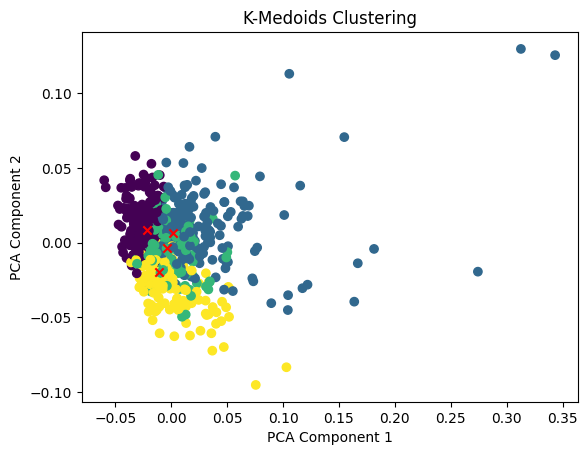

In [12]:
from sklearn.decomposition import PCA

# Reduce dimensions for visualization
pca = PCA(n_components=2)
reduced_X = pca.fit_transform(sentence_vectors)

# Plot the clusters
plt.scatter(reduced_X[:, 0], reduced_X[:, 1], c=kmedoids.labels_, cmap='viridis', marker='o')
plt.scatter(reduced_X[medoid_indices, 0], reduced_X[medoid_indices, 1], c='red', marker='x')
plt.title('K-Medoids Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()


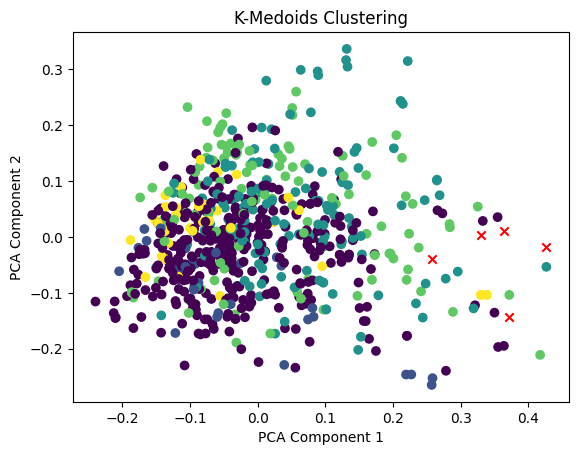

In [44]:
# Plot the clusters
plt.scatter(reduced_X[:, 0], reduced_X[:, 2], c=kmedoids.labels_, cmap='viridis', marker='o')
plt.scatter(reduced_X[medoid_indices, 0], reduced_X[medoid_indices, 1], c='red', marker='x')
plt.title('K-Medoids Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

In [80]:
txt_order

['289.txt',
 '504.txt',
 '262.txt',
 '276.txt',
 '510.txt',
 '538.txt',
 '29.txt',
 '15.txt',
 '114.txt',
 '672.txt',
 '666.txt',
 '100.txt',
 '128.txt',
 '470.txt',
 '316.txt',
 '302.txt',
 '464.txt',
 '458.txt',
 '459.txt',
 '303.txt',
 '465.txt',
 '471.txt',
 '317.txt',
 '129.txt',
 '667.txt',
 '101.txt',
 '115.txt',
 '673.txt',
 '14.txt',
 '28.txt',
 '539.txt',
 '277.txt',
 '511.txt',
 '505.txt',
 '263.txt',
 '288.txt',
 '513.txt',
 '275.txt',
 '261.txt',
 '507.txt',
 '249.txt',
 '16.txt',
 '103.txt',
 '665.txt',
 '671.txt',
 '117.txt',
 '659.txt',
 '498.txt',
 '467.txt',
 '301.txt',
 '315.txt',
 '473.txt',
 '329.txt',
 'labels.csv',
 '328.txt',
 '314.txt',
 '472.txt',
 '466.txt',
 '300.txt',
 '499.txt',
 '658.txt',
 '670.txt',
 '116.txt',
 '102.txt',
 '664.txt',
 '17.txt',
 '248.txt',
 '260.txt',
 '506.txt',
 '512.txt',
 '274.txt',
 '258.txt',
 '270.txt',
 '516.txt',
 '502.txt',
 '264.txt',
 '13.txt',
 '648.txt',
 '660.txt',
 '106.txt',
 '112.txt',
 '674.txt',
 '489.txt',
 '338.tx

In [88]:
# Functions defined
def read_text_files(directory):
    texts = []
    fn = []
    for filename in os.listdir(directory):
        
        if filename.endswith(".txt"):
            with open(os.path.join(directory, filename), 'r', encoding='utf-8') as file:
                texts.append(file.read())
                fn.append(filename)
                
    return texts, fn

check_txt_use, fn = read_text_files('../../Data/txt_new/')

In [89]:
for i in tqdm(range(len(check_txt_use))):
    for j in range(i+1, len(check_txt_use)):
        if check_txt_use[i] == check_txt_use[j]:
            print(fn[i], fn[j])

100%|██████████| 681/681 [00:00<00:00, 39129.29it/s]

470.txt 18.txt
471.txt 19.txt
102.txt 321.txt
62.txt 93.txt
639.txt 84.txt
603.txt 600.txt
372.txt 371.txt
156.txt 494.txt
3.txt 25.txt
86.txt 641.txt
87.txt 642.txt
85.txt 640.txt
486.txt 487.txt
